**Parameterization of Temperature and Salinity with depth**

In [1]:
from netCDF4 import *
import numpy as np
from scipy import interpolate
import scipy.io
import matplotlib.pyplot as plt
import paramTSz as func
import stericheight as sth
import geopy.distance
from sympy.solvers.solveset import linsolve
from math import *
%matplotlib inline

ds = Dataset('EN.4.2.1.f.profiles.g10.201901.nc')
# for i in ds.variables:
#    print(i, ds.variables[i])
    
# temperature (in degC)
T = ds.variables['TEMP'][:]

# practical salinity
PSAL = ds.variables['PSAL_CORRECTED'][:]

# depth
depth = ds.variables['DEPH_CORRECTED'][:]

lat = ds.variables['LATITUDE'][:]
long = ds.variables['LONGITUDE'][:]

Functions to interpolate gridded T,S at given locations

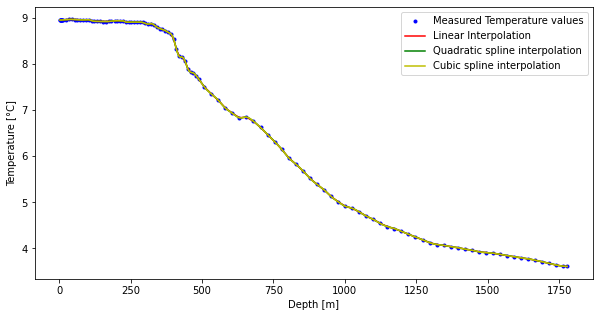

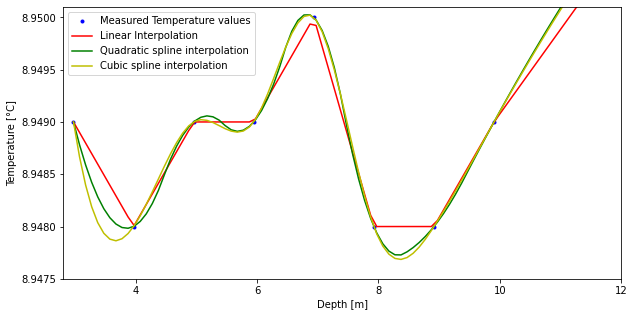

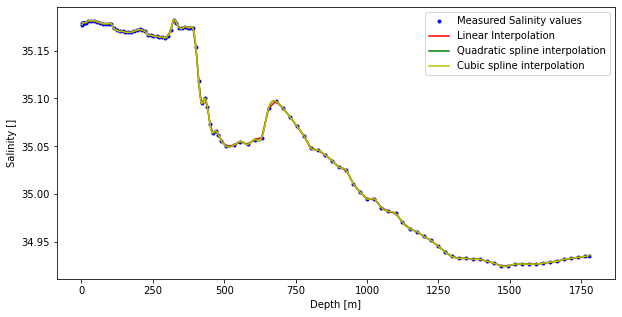

In [2]:
# remove masked values
T_new = T[0,:][~T[0,:].mask]
PSAL_new = PSAL[0,:][~PSAL[0,:].mask]
depth_new = depth[0,:][~depth[0,:].mask]

x = depth_new

# interpolate T,S at given locations
f_T, x_new = func.interpolateTS(x, T_new, "linear")
f2_T, x_new = func.interpolateTS(x, T_new, "quadratic")
f3_T, x_new = func.interpolateTS(x, T_new, "cubic")

f_PSAL, x_new = func.interpolateTS(x, PSAL_new, "linear")
f2_PSAL, x_new = func.interpolateTS(x, PSAL_new, "quadratic")
f3_PSAL, x_new = func.interpolateTS(x, PSAL_new, "cubic")

plt.figure(figsize=(10,5))
plt.plot(x,T_new,'b.',x_new,f_T(x_new), 'r-')
plt.plot(x_new,f2_T(x_new), 'g-')
plt.plot(x_new,f3_T(x_new), 'y-')
plt.xlabel("Depth [m]")
plt.ylabel("Temperature [°C]")
plt.legend(["Measured Temperature values","Linear Interpolation", "Quadratic spline interpolation", "Cubic spline interpolation"])
plt.show()

plt.figure(figsize=(10,5))
plt.xlim([2.8,12.])
plt.ylim([8.9475,8.9501])
plt.plot(x,T_new,'b.', x_new, f_T(x_new), 'r-')
plt.plot(x_new, f2_T(x_new), 'g-')
plt.plot(x_new, f3_T(x_new), 'y-')
plt.xlabel("Depth [m]")
plt.ylabel("Temperature [°C]")
plt.legend(["Measured Temperature values","Linear Interpolation", "Quadratic spline interpolation", "Cubic spline interpolation"])
plt.show()

plt.figure(figsize=(10,5))
plt.plot(x,PSAL_new,'b.',x_new,f_PSAL(x_new), 'r-')
plt.plot(x_new,f2_PSAL(x_new), 'g-')
plt.plot(x_new,f3_PSAL(x_new), 'y-')
plt.xlabel("Depth [m]")
plt.ylabel("Salinity []")
plt.legend(["Measured Salinity values","Linear Interpolation", "Quadratic spline interpolation", "Cubic spline interpolation"])
plt.show()

Plots of T vs. depth, S vs. depth and T vs. S

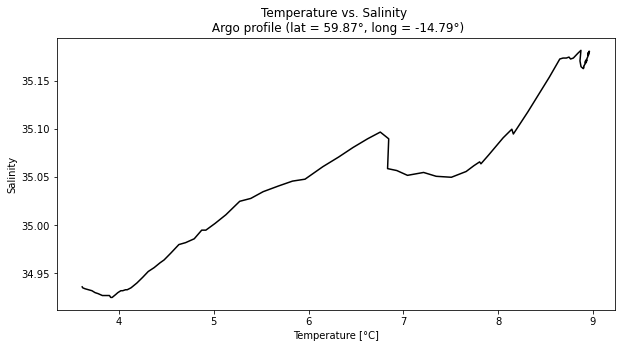

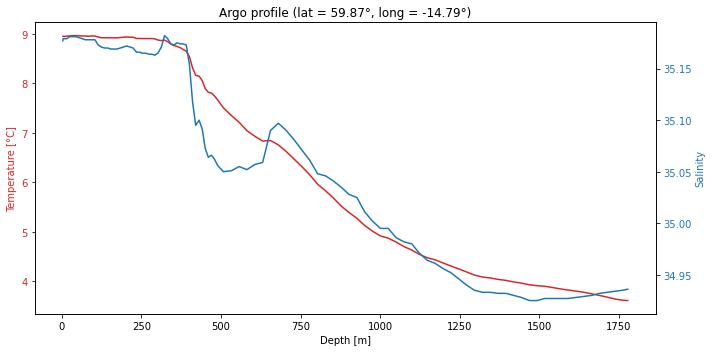

In [3]:
plt.figure(figsize=(10,5))
plt.plot(T[0,:], PSAL[0,:],'k')
plt.xlabel("Temperature [°C]")
plt.ylabel("Salinity")
plt.title('Temperature vs. Salinity \n Argo profile (lat = '+str(round(lat[0],2))+'°'+', long = '+str(round(long[0],2))+'°)')
plt.show()

func.plotDepthST(T[0,:], PSAL[0,:], depth[0,:], lat[0], long[0])

**Interpolate T,S at the bottom pressure locations**

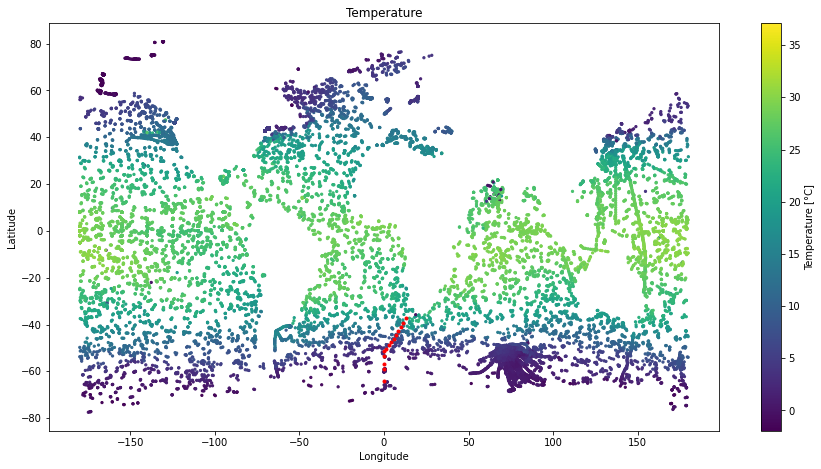

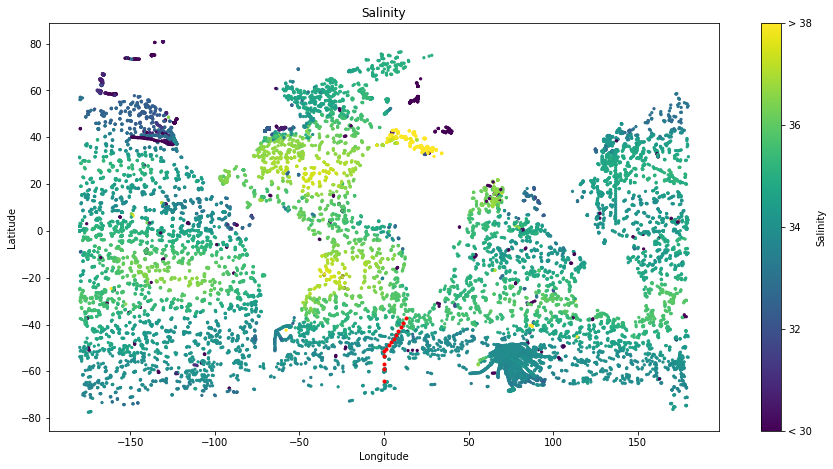

In [4]:
# read bottom pression data (see https://github.com/strawpants/schroeter-southatlantic-2019/tree/master/analysis/data)
data = scipy.io.loadmat('OBPv2.mat')
degE = data['degE'] 
degN = data['degN'] 
P_oc = data['OPRES']
time = data['OTIME']

marker_size=5
plt.figure(figsize=(15,7.5))
plt.scatter(long, lat, marker_size, c=T[:,0])
plt.plot(degE, degN, 'r.')
plt.title("Temperature")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cbar= plt.colorbar()
cbar.set_label("Temperature [°C]")
plt.show()

plt.figure(figsize=(15,7.5))
plt.scatter(long, lat, marker_size, c=PSAL[:,0])
plt.plot(degE, degN, 'r.')
plt.title("Salinity")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cbar= plt.colorbar(ticks=[30, 32, 34, 36, 38])
plt.clim(30,38)
cbar.ax.set_yticklabels(['< 30', '32', '34','36','> 38'])
cbar.set_label("Salinity")
plt.show()

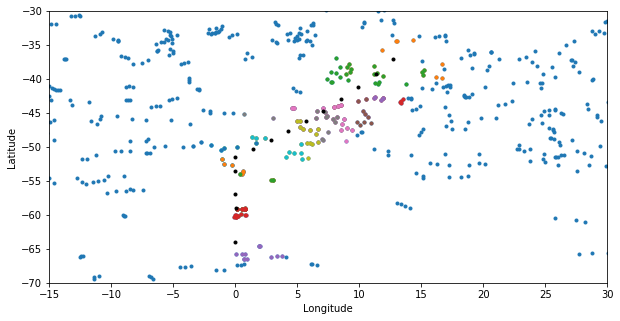

In [5]:
# Merge most similar Temperature/Salinity measurements in a cluster
plt.figure(figsize=(10,5))
plt.ylim([-70,-30])
plt.xlim([-15,30])
plt.plot(long, lat, '.')
for i in range(len(degE)):
    idx_T, cluster_T, lat_cluster_T, long_cluster_T = func.clustering(lat, long, degN[i], degE[i], T[:,0], 3) # Temperature
    idx_S, cluster_S, lat_cluster_S, long_cluster_S = func.clustering(lat, long, degN[i], degE[i], PSAL[:,0], 1) # Salinity
    plt.plot(long_cluster_T, lat_cluster_T, '.')
    globals()["T_all_cluster_" + str(i)] = np.array(T[list(idx_T.astype(int)),:]) # Temperature
    globals()["T_depth_cluster_" + str(i)] = np.array(depth[list(idx_T.astype(int)),:])
    
    globals()["S_all_cluster_" + str(i)] = np.array(PSAL[list(idx_S.astype(int)),:]) # Salinity
    globals()["S_depth_cluster_" + str(i)] = np.array(depth[list(idx_S.astype(int)),:])
plt.plot(degE, degN, 'k.')
plt.xlabel("Longitude")
plt.ylabel("Latitude")      
plt.show()

Cluster 0 , # parameters (T) =  (9,)
Cluster 0 , # parameters (S) =  (9,)


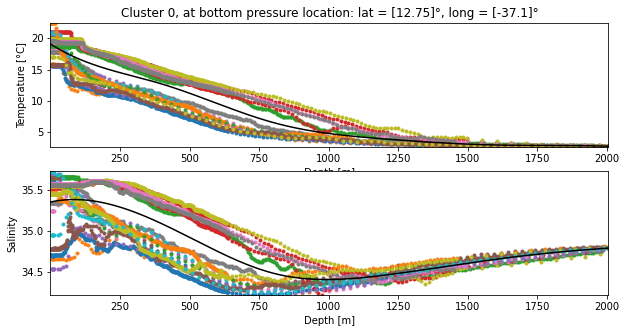

Cluster 1 , # parameters (T) =  (9,)
Cluster 1 , # parameters (S) =  (9,)


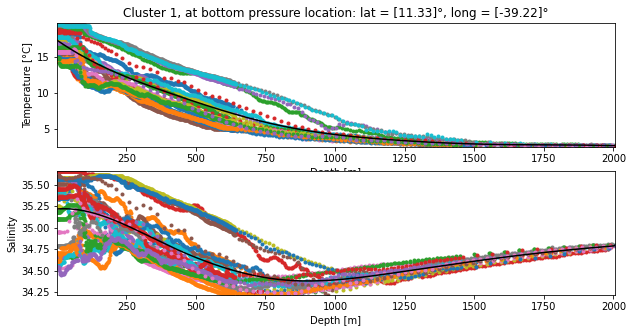

Cluster 2 , # parameters (T) =  (8,)
Cluster 2 , # parameters (S) =  (8,)


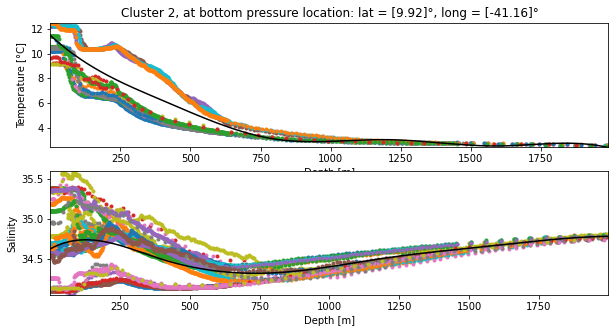

Cluster 3 , # parameters (T) =  (8,)
Cluster 3 , # parameters (S) =  (9,)


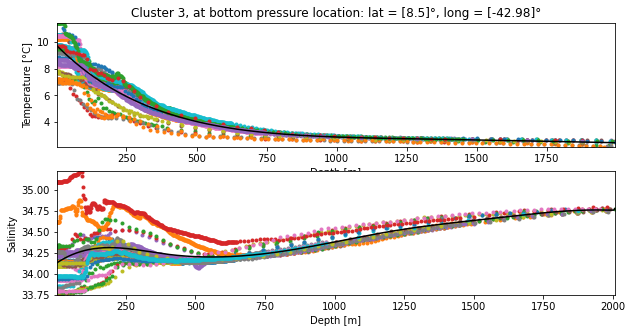

Cluster 4 , # parameters (T) =  (8,)
Cluster 4 , # parameters (S) =  (9,)


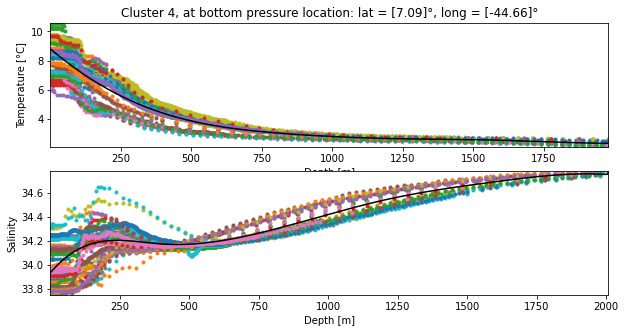

Cluster 5 , # parameters (T) =  (9,)
Cluster 5 , # parameters (S) =  (9,)


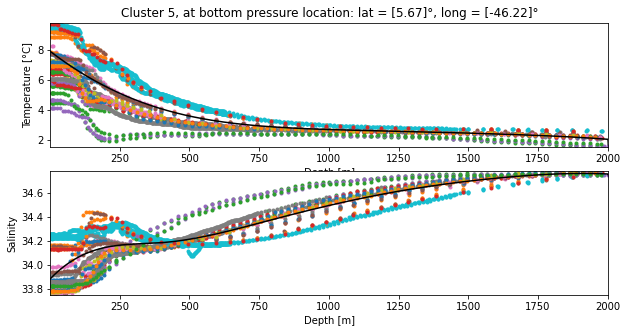

Cluster 6 , # parameters (T) =  (9,)
Cluster 6 , # parameters (S) =  (9,)


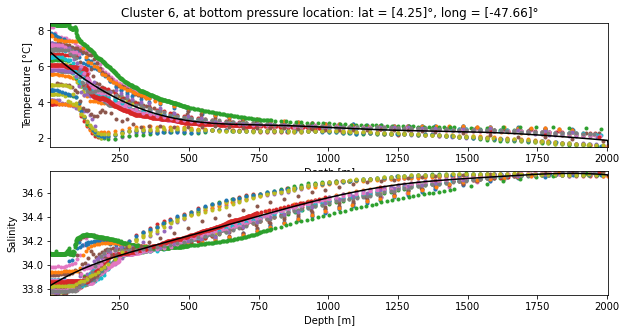

Cluster 7 , # parameters (T) =  (9,)
Cluster 7 , # parameters (S) =  (9,)


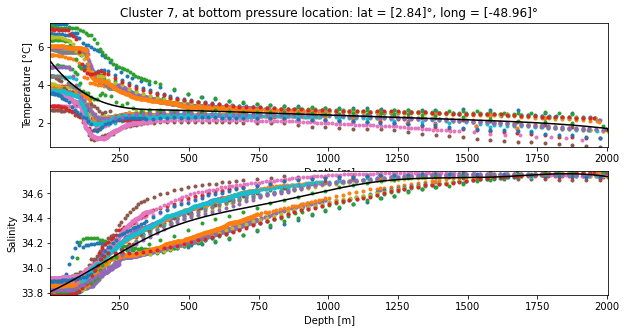

Cluster 8 , # parameters (T) =  (9,)
Cluster 8 , # parameters (S) =  (9,)


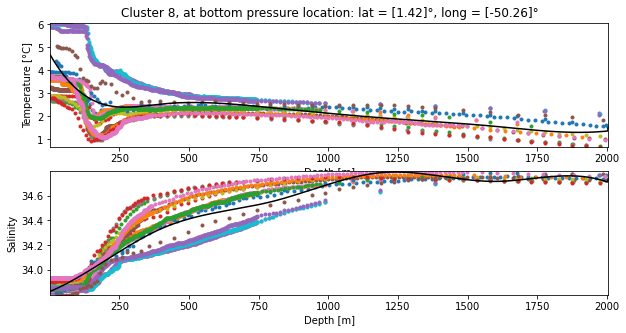

Cluster 9 , # parameters (T) =  (9,)
Cluster 9 , # parameters (S) =  (9,)


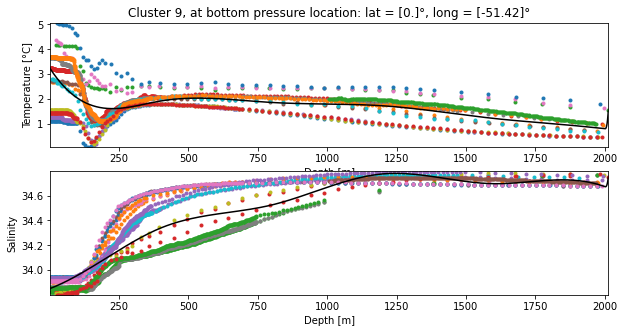

Cluster 10 , # parameters (T) =  (8,)
Cluster 10 , # parameters (S) =  (8,)


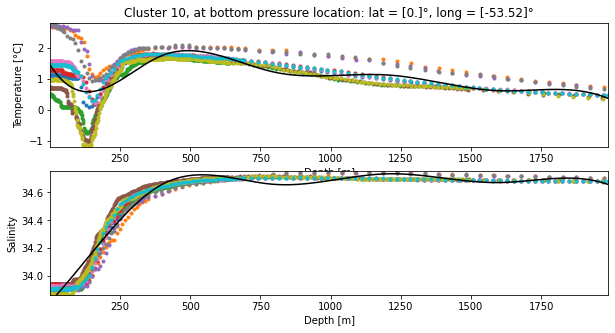

Cluster 11 , # parameters (T) =  (8,)
Cluster 11 , # parameters (S) =  (8,)


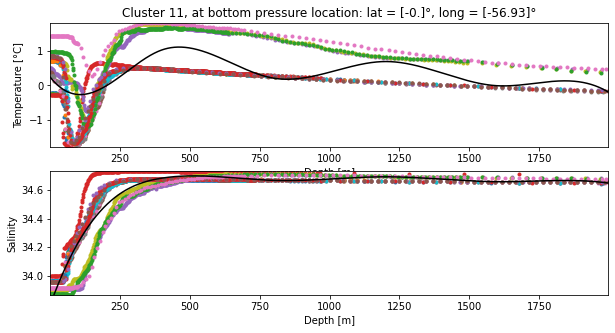

Cluster 12 , # parameters (T) =  (8,)
Cluster 12 , # parameters (S) =  (8,)


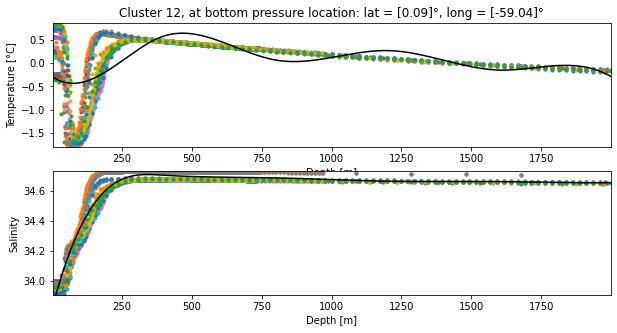

Cluster 13 , # parameters (T) =  (8,)
Cluster 13 , # parameters (S) =  (8,)


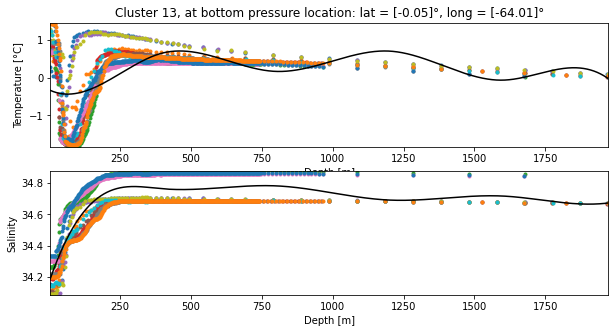

In [6]:
# Approximation of T,S at the bottom pressure locations => cubic b-splines
rms_S = []
rms_T = []
for j in range(len(degE)):
    # get all T/S and z values belonging to a cluster
    T_depth_cluster = globals()["T_depth_cluster_" + str(j)] 
    T_cluster = globals()["T_all_cluster_" + str(j)]
    
    S_depth_cluster = globals()["S_depth_cluster_" + str(j)]
    S_cluster = globals()["S_all_cluster_" + str(j)]
    
    # reshape matrices in a vector
    T_new = T_cluster.ravel()
    T_depth_new = T_depth_cluster.ravel()
    S_new = S_cluster.ravel()
    S_depth_new = S_depth_cluster.ravel()
    
    T_depth_new = T_depth_new[T_depth_new != 99999] # delete masked values (=999999)
    T_new = T_new[T_new != 99999]
    S_depth_new = S_depth_new[S_depth_new != 99999]
    S_new = S_new[S_new != 99999]
    
    S_depth_sort = np.sort(S_depth_new) # sort the depth values
    T_depth_sort = np.sort(T_depth_new)
    S_new_ = S_new[np.argsort(S_depth_new)] # sort T/S in corresponding order
    T_new_ = T_new[np.argsort(T_depth_new)]
    
    # node distance
    dkappa_T = 400
    dkappa_S = 400
#     dkappa_T = ceil(np.max(T_depth_new)/5)
#     dkappa_S = ceil(np.max(S_depth_new)/5)

    # nodes
    kappa_x_T = np.arange(0, ceil(np.max(T_depth_new)/dkappa_T)*dkappa_T + dkappa_T, dkappa_T)
    kappa_x_S = np.arange(0, ceil(np.max(S_depth_new)/dkappa_S)*dkappa_S + dkappa_S, dkappa_S)
    
    # get designmatrices
    A_T = func.getA(kappa_x_T, dkappa_T, T_depth_sort)
    A_S = func.getA(kappa_x_S, dkappa_S, S_depth_sort)
    
    xS_T,lS_T,v_T,rp_T = func.linearGMM(A_T, T_new_)
    xS_S,lS_S,v_S,rp_S = func.linearGMM(A_S, S_new_)
    
    rms_S.append(np.sqrt(np.mean(np.square(v_S))))
    rms_T.append(np.sqrt(np.mean(np.square(v_T))))
    
    #-------------------------- Evaluation of the functions on an equidistant grid
    t_Raster_S = np.arange(S_depth_sort[0], S_depth_sort[-1], (S_depth_sort[-1]-S_depth_sort[0])/10000) # vector with equidistant values
    t_Raster_T = np.arange(T_depth_sort[0], T_depth_sort[-1], (T_depth_sort[-1]-T_depth_sort[0])/10000)
    
    Ax_S = func.getA(kappa_x_S, dkappa_S, t_Raster_S)
    Ax_T = func.getA(kappa_x_T, dkappa_T, t_Raster_T)

    f_Raster_S = Ax_S.dot(xS_S)
    f_Raster_T = Ax_T.dot(xS_T)
    #--------------------------
    
    cluster = plt.figure(figsize=(10,5))
    plt.subplot(211)
    print("Cluster", str(j), ", # parameters (T) = ", xS_T.shape)
    plt.title('Cluster '+str(j)+', at bottom pressure location: lat = '+str(np.round(degE[j],2))+'°'+', long = '+str(np.round(degN[j],2))+'°')
    for i in range(len(T_depth_cluster)):
        plt.plot(T_depth_cluster[i,:], T_cluster[i,:], '.')
        plt.xlim([np.min(T_depth_cluster), np.max(T_depth_cluster[T_depth_cluster != 99999])])
        plt.ylim([np.min(T_cluster), np.max(T_cluster[T_cluster != 99999])])
        plt.xlabel("Depth [m]")
        plt.ylabel("Temperature [°C]")
    plt.plot(t_Raster_T, f_Raster_T, 'k')
    
    plt.subplot(212)
    print("Cluster", str(j), ", # parameters (S) = ", xS_S.shape)
    for i in range(len(S_depth_cluster)):
        plt.plot(S_depth_cluster[i,:], S_cluster[i,:], '.')
        plt.xlim([np.min(S_depth_cluster), np.max(S_depth_cluster[S_depth_cluster != 99999])])
        plt.ylim([np.min(S_cluster[S_cluster >= 30]), np.max(S_cluster[S_cluster != 99999])])
        plt.xlabel("Depth [m]")
        plt.ylabel("Salinity")
    plt.plot(t_Raster_S, f_Raster_S, 'k')
    plt.show()
    #cluster.savefig('cluster'+str(j)+'.png', bbox_inches='tight')
    

Apply fitting procedure to Argo profiles in vicinity

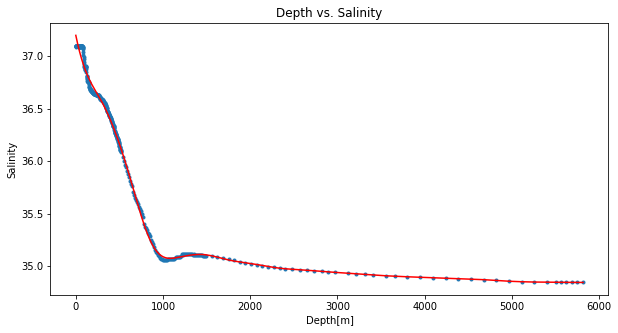

Max. depth = 5817.643 [m] # parameters: 23


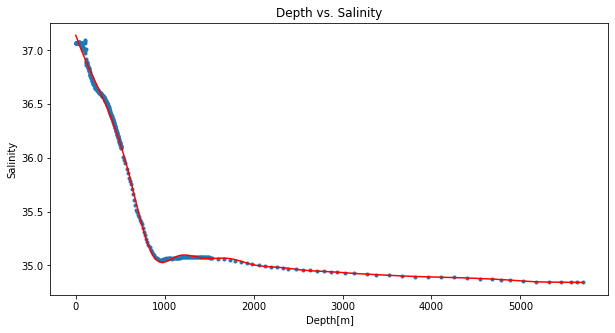

Max. depth = 5705.445 [m] # parameters: 23


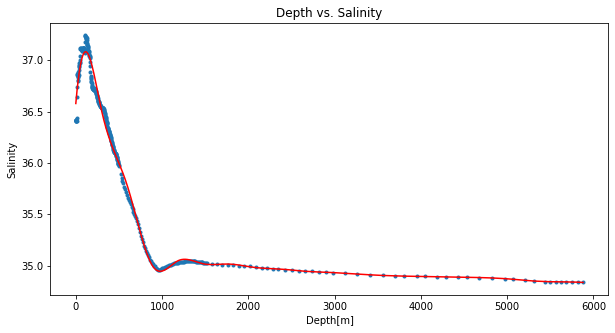

Max. depth = 5880.489 [m] # parameters: 23


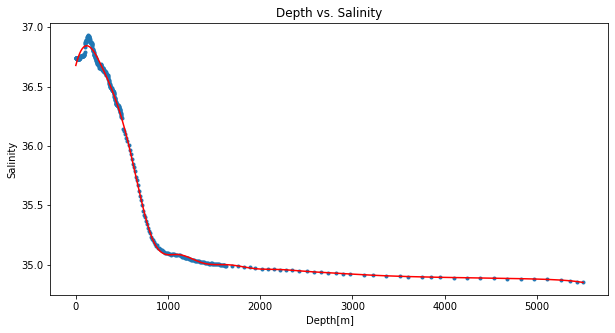

Max. depth = 5501.1924 [m] # parameters: 23


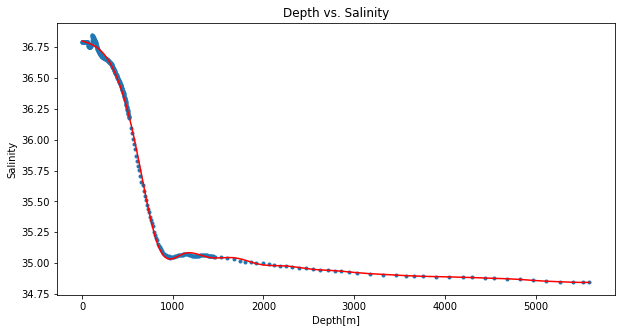

Max. depth = 5594.616 [m] # parameters: 23


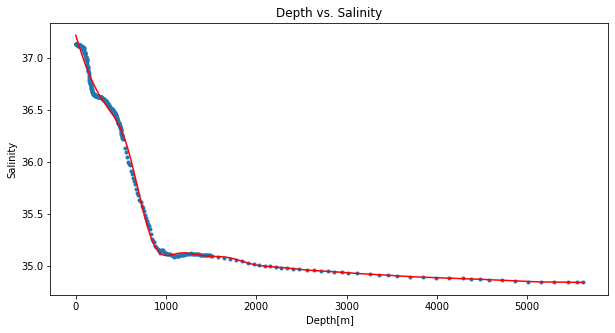

Max. depth = 5620.7554 [m] # parameters: 23


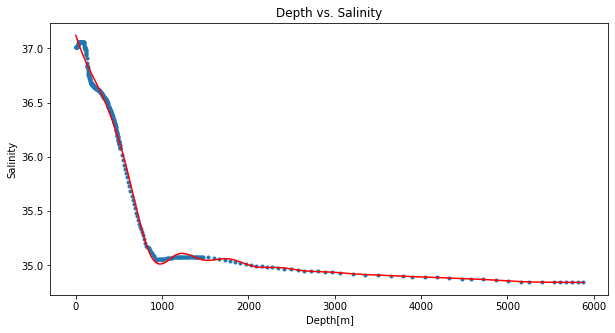

Max. depth = 5876.674 [m] # parameters: 23


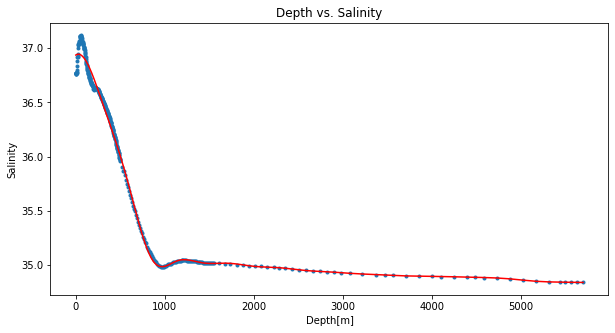

Max. depth = 5699.5796 [m] # parameters: 23


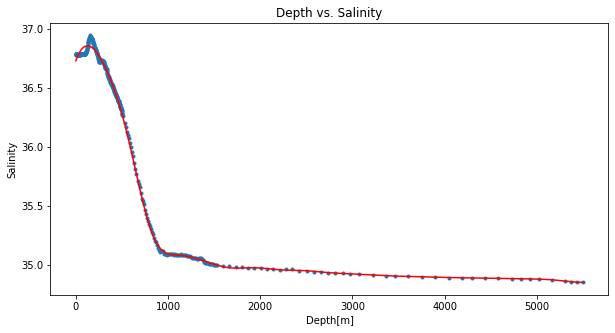

Max. depth = 5502.1885 [m] # parameters: 23


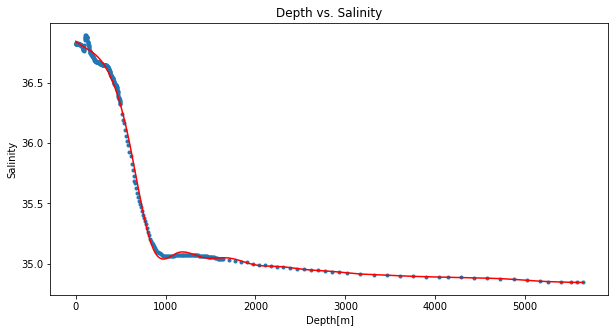

Max. depth = 5646.393 [m] # parameters: 23


In [7]:
# Find Argo profiles in vicinity
# arr1, arr2 = np.where((depth > 4000) & (depth < 99999) & (T < 99999)) # arr1... row, arr2... column
# arr1 = np.unique(arr1) # delete duplicate elements
# depth_vicinity = np.array(depth[list(arr1),:])
# T_vicinity = np.array(T[list(arr1),:])

arr1, arr2 = np.where((depth > 4000) & (depth < 99999) & (PSAL < 99999)) # arr1... row, arr2... column
arr1 = np.unique(arr1) # delete duplicate elements
depth_vicinity = np.array(depth[list(arr1),:])
T_vicinity = np.array(PSAL[list(arr1),:])

for i in range(10): #len(T_vicinity)
    depth_vic = depth_vicinity[i,:][depth_vicinity[i,:] < 8000]
    T_vic = T_vicinity[i,:][T_vicinity[i,:] < 50]
    
#     T_vic = T_vic[np.where(depth_vic > 2000)]
#     depth_vic = depth_vic[np.where(depth_vic > 2000)]
    
    # Approximation of Argo profiles in vicinity
    # adapt node distance to number of max depth
    dkappa_depth = ceil(np.max(depth_vic)/20) #ceil(np.max(depth_vic)/6)

    # nodes
    kappa_x_depth = np.arange(np.min(depth_vic), ceil(np.max(depth_vic)/dkappa_depth)*dkappa_depth + dkappa_depth, dkappa_depth)
    
    A_vic = func.getA(kappa_x_depth, dkappa_depth, depth_vic)
    xS_vic,lS_vic,v_vic,rp_vic = func.linearGMM(A_vic, T_vic) 
    
    vic = plt.figure(figsize=(10,5))
    plt.plot(depth_vic, T_vic, '.')
    plt.plot(depth_vic, lS_vic, 'r')
#     plt.ylabel("Temperature [°C]")
    plt.xlabel("Depth[m]")
#     plt.title('Depth vs. Temperature')
    plt.ylabel("Salinity")
    plt.title('Depth vs. Salinity')
    plt.show()
    #vic.savefig('vic_S'+str(i)+'.png', bbox_inches='tight')
    print("Max. depth =", np.max(depth_vic), "[m]", "# parameters:", len(xS_vic))

Compute misfits (of EN4 versus estimated functional) and visualize. Possible misfits criteria: RMS, Akaike Criterion

In [8]:
RMS_T = [round(x,2) for x in rms_T]
RMS_S = [round(x,2) for x in rms_S]
print(RMS_T)
print(RMS_S)

[2.18, 2.08, 1.44, 0.6, 0.73, 1.04, 0.78, 0.86, 0.85, 0.65, 0.51, 0.64, 0.48, 0.56]
[0.27, 0.26, 0.41, 0.18, 0.1, 0.12, 0.09, 0.1, 0.11, 0.13, 0.06, 0.08, 0.05, 0.09]


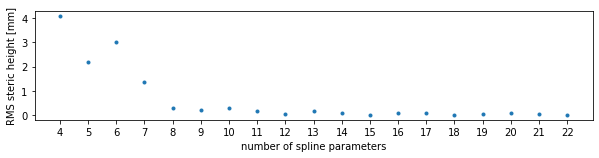

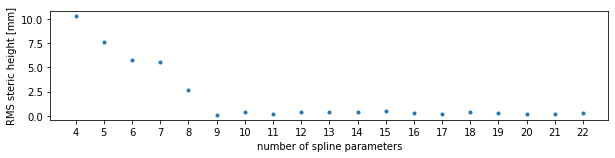

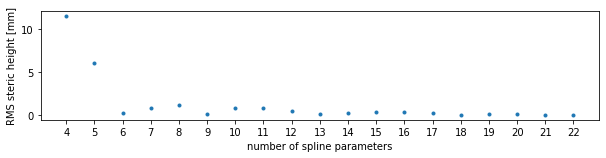

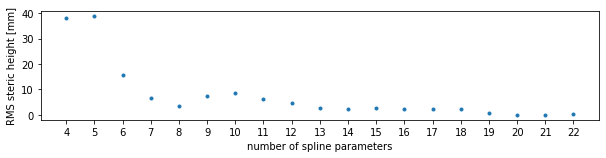

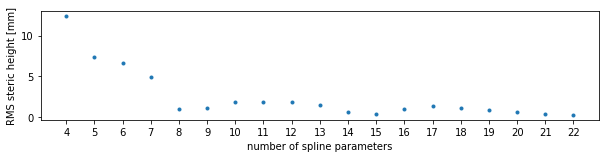

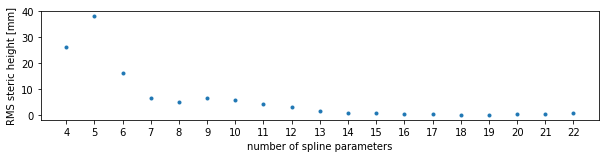

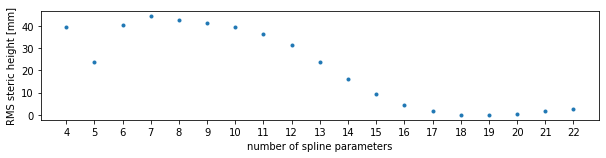

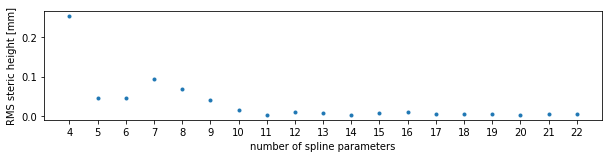

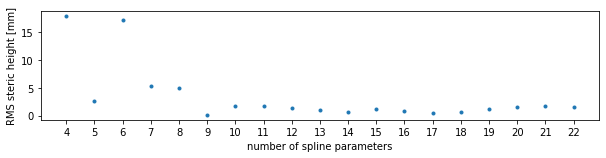

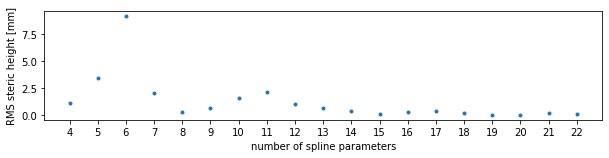

In [9]:
for i in range(10): #len(T)
    dh_prof = []
    dh_app = []
    numT = []
    numS = []
    for j in range(1,20):
        # (1) estimate a b-spline through the T,S data
        T_new = T[i,:][~T[i,:].mask]
        S_new = PSAL[i,:][~PSAL[i,:].mask]
        z = depth[i,:][~depth[i,:].mask]

        # adapt node distance to number of max depth
        dkappa_depth = ceil(np.max(z)/j) #ceil(np.max(depth_vic)/20)

        # nodes
        kappa_x_depth = np.arange(np.min(z), ceil(np.max(z)/dkappa_depth)*dkappa_depth + dkappa_depth, dkappa_depth)

        A_ = func.getA(kappa_x_depth, dkappa_depth, z)
        xS_T,lS_T,v_T,rp_T = func.linearGMM(A_, T_new)
        xS_S,lS_S,v_S,rp_S = func.linearGMM(A_, S_new) 
        numT.append(len(xS_T))
        numS.append(len(xS_S))

    #     plt.figure()
    #     plt.plot(z, T_new, 'b.')
    #     plt.plot(z, lS_T, 'r')
    #     plt.ylabel("Temperature [°C]")
    #     plt.xlabel("Depth[m]")
    #     plt.title('Depth vs. Temperature')
    #     plt.show()

    #     plt.figure()
    #     plt.plot(z, S_new, 'b.')
    #     plt.plot(z, lS_S, 'r')
    #     plt.xlabel("Depth[m]")
    #     plt.ylabel("Salinity")
    #     plt.title('Depth vs. Salinity')
    #     plt.show()

        # (2) compute the steric height change of the profile from the input data and approximated data.
        dh_prof.append(sth.TSz_to_h_steric2(T_new, S_new, -z, lat[i], long[i]))
        dh_app.append(sth.TSz_to_h_steric2(lS_T, lS_S, -z, lat[i], long[i]))

    # (3) This difference can be used as an overall metric (small is good), maybe plot them as a bunch of points dependent on the
    # number of spline parameters? (so Y axis RMS(sterheight_orig-sterheight_approx) , X axis number of spline parameters)
    diff = (np.asarray(dh_prof) - np.asarray(dh_app).T)[0]
    rms_sth = []
    for i in range(len(diff)):
        rms_sth.append(np.sqrt(np.mean(np.square(diff[i]))))
    rms_sth = np.asarray(rms_sth)    
    # print(diff)
    # print(rms_sth)
    # print(numT,numS)

    plt.figure(figsize=(10,2))
    plt.plot(numT, rms_sth*10**3, '.')
    plt.xlabel('number of spline parameters')
    plt.ylabel('RMS steric height [mm]')
    plt.xticks(numT)
    plt.show()